# 3-Layer Neural Network for Non-linear Regression (TensorFlow Low-level Implementation)

This notebook implements a 3-layer neural network using TensorFlow with a low-level approach. We'll manually define the forward and backward passes without using high-level APIs like Keras. We'll continue to use the same 3-variable non-linear function for our synthetic dataset.

Key features:
- Manual implementation of network parameters
- Using TensorFlow's automatic differentiation
- Using `einsum` for matrix operations as specified
- Implementing the training loop from scratch

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the function to generate synthetic data
def true_function(X):
    """
    Non-linear function with 3 variables
    X should be a matrix with 3 columns
    """
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + 0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

# Generate synthetic dataset
def generate_data(n_samples=1000):
    # Generate random inputs
    X = tf.cast(tf.random.uniform((n_samples, 3), -2, 2), tf.float32)

    # Calculate true output values
    y_true = true_function(X)

    # Add some noise
    y = y_true + tf.random.normal((n_samples,), 0, 0.5)

    return X, tf.reshape(y, (-1, 1))

# Generate training data
X_train, y_train = generate_data(1000)

# Generate test data
X_test, y_test = generate_data(200)

print(f"Training data shape: X = {X_train.shape}, y = {y_train.shape}")
print(f"Test data shape: X = {X_test.shape}, y = {y_test.shape}")

Training data shape: X = (1000, 3), y = (1000, 1)
Test data shape: X = (200, 3), y = (200, 1)


## Neural Network Implementation (TensorFlow Low-level)

Now we'll implement our 3-layer neural network using TensorFlow's low-level API. We'll manually define the weights and biases, and use `einsum` for matrix operations as specified in the requirements. We'll also implement the forward pass, loss computation, and parameter updates.

In [3]:
class NeuralNetworkTF:
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        # Initialize weights using He initialization
        self.W1 = tf.Variable(
            tf.random.normal([input_size, hidden1_size], stddev=tf.sqrt(2/input_size)),
            name="W1"
        )
        self.b1 = tf.Variable(tf.zeros([hidden1_size]), name="b1")

        self.W2 = tf.Variable(
            tf.random.normal([hidden1_size, hidden2_size], stddev=tf.sqrt(2/hidden1_size)),
            name="W2"
        )
        self.b2 = tf.Variable(tf.zeros([hidden2_size]), name="b2")

        self.W3 = tf.Variable(
            tf.random.normal([hidden2_size, output_size], stddev=tf.sqrt(2/hidden2_size)),
            name="W3"
        )
        self.b3 = tf.Variable(tf.zeros([output_size]), name="b3")

        # Store parameters in a list for easy access
        self.parameters = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]

    def forward(self, X):
        # Using einsum for matrix multiplication as specified
        # First hidden layer
        z1 = tf.einsum('bi,ij->bj', X, self.W1) + self.b1
        a1 = tf.nn.relu(z1)

        # Second hidden layer
        z2 = tf.einsum('bi,ij->bj', a1, self.W2) + self.b2
        a2 = tf.nn.relu(z2)

        # Output layer (linear activation for regression)
        z3 = tf.einsum('bi,ij->bj', a2, self.W3) + self.b3

        return z3

    def loss_fn(self, y_pred, y_true):
        # Mean Squared Error
        return tf.reduce_mean(tf.square(y_pred - y_true))

# Define the training step using gradient tape
@tf.function
def train_step(model, X, y, optimizer):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model.forward(X)

        # Compute loss
        loss = model.loss_fn(y_pred, y)

    # Compute gradients
    gradients = tape.gradient(loss, model.parameters)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.parameters))

    return loss

# Create model instance
input_size = 3
hidden1_size = 10
hidden2_size = 5
output_size = 1

model = NeuralNetworkTF(input_size, hidden1_size, hidden2_size, output_size)

# Create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Training loop
num_epochs = 3000
batch_size = 64
print_interval = 100
losses = []

# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)

start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    # Train on batches
    for X_batch, y_batch in train_dataset:
        batch_loss = train_step(model, X_batch, y_batch, optimizer)
        epoch_loss += batch_loss
        num_batches += 1

    # Average loss for the epoch
    avg_loss = epoch_loss / num_batches

    # Print progress
    if epoch % print_interval == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.6f}")

    # Store loss value
    if epoch % 10 == 0:
        losses.append(avg_loss.numpy())

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

Epoch 0/3000, Loss: 6.434443
Epoch 100/3000, Loss: 0.312632
Epoch 200/3000, Loss: 0.285843
Epoch 300/3000, Loss: 0.259618
Epoch 400/3000, Loss: 0.259972
Epoch 500/3000, Loss: 0.256943
Epoch 600/3000, Loss: 0.262130
Epoch 700/3000, Loss: 0.252699
Epoch 800/3000, Loss: 0.251010
Epoch 900/3000, Loss: 0.245727
Epoch 1000/3000, Loss: 0.253144
Epoch 1100/3000, Loss: 0.255611
Epoch 1200/3000, Loss: 0.251866
Epoch 1300/3000, Loss: 0.255885
Epoch 1400/3000, Loss: 0.251302
Epoch 1500/3000, Loss: 0.251705
Epoch 1600/3000, Loss: 0.244210
Epoch 1700/3000, Loss: 0.244966
Epoch 1800/3000, Loss: 0.247517
Epoch 1900/3000, Loss: 0.247925
Epoch 2000/3000, Loss: 0.248246
Epoch 2100/3000, Loss: 0.245148
Epoch 2200/3000, Loss: 0.245595
Epoch 2300/3000, Loss: 0.245064
Epoch 2400/3000, Loss: 0.248676
Epoch 2500/3000, Loss: 0.246245
Epoch 2600/3000, Loss: 0.242975
Epoch 2700/3000, Loss: 0.244262
Epoch 2800/3000, Loss: 0.253115
Epoch 2900/3000, Loss: 0.249389
Training completed in 108.57 seconds


## Model Evaluation and Visualization

Now let's evaluate our TensorFlow model on the test set and visualize the training progress and predictions.

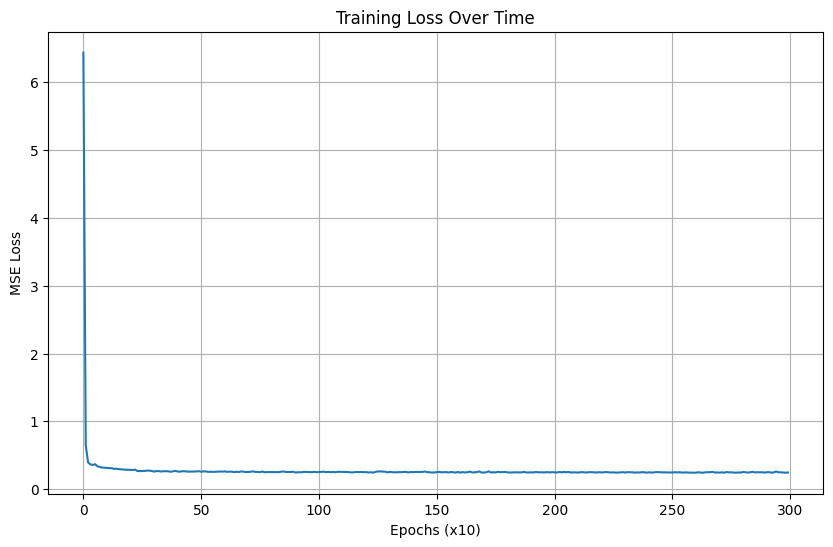

Test MSE Loss: 0.308259


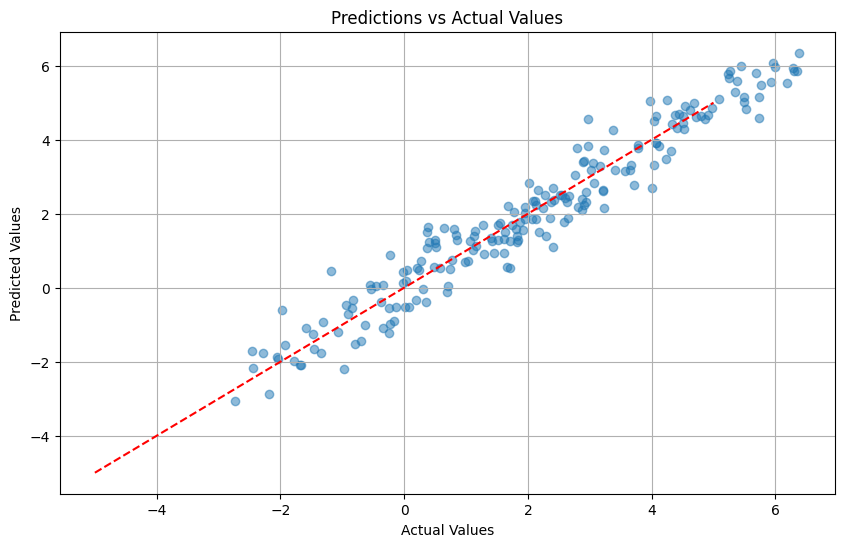

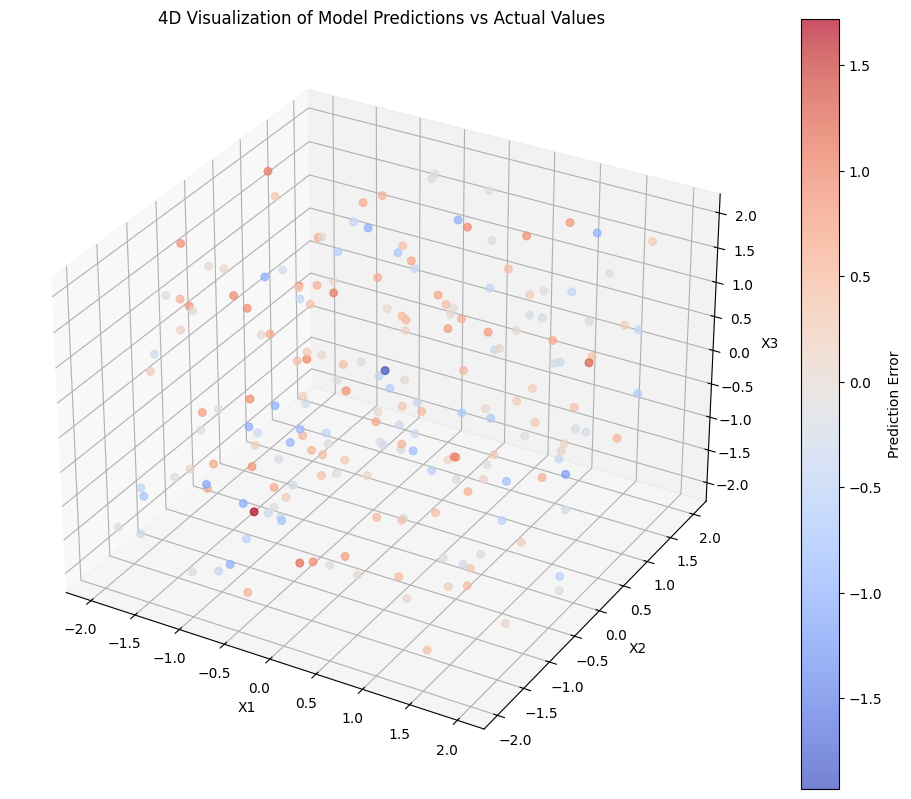

In [4]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epochs (x10)')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Evaluate on test set
y_pred_test = model.forward(X_test)
test_loss = model.loss_fn(y_pred_test, y_test).numpy()
print(f"Test MSE Loss: {test_loss:.6f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_test.numpy(), alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Create a 4D visualization (3D plot with color as the 4th dimension)
def visualize_4d(X, y_true, y_pred, title):
    # Convert tensors to numpy
    X_np = X.numpy()
    y_true_np = y_true.numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    # Create a 3D scatter plot with color as the 4th dimension
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Calculate prediction error for coloring
    error = y_true_np - y_pred_np

    # Create the scatter plot
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=error,  # Use error for coloring
                          cmap=cm.coolwarm,
                          marker='o',
                          alpha=0.7,
                          s=30)

    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Prediction Error')

    # Set labels and title
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)

    # Show the plot
    plt.show()

# Generate sample data points for visualization
X_vis, y_vis = generate_data(200)

# Get predictions for visualization
y_vis_pred = model.forward(X_vis)

# Create 4D visualization
visualize_4d(X_vis, y_vis, y_vis_pred, '4D Visualization of Model Predictions vs Actual Values')

## 2D Slice Visualization

To better understand how our model performs across different values of our three input variables, we'll create 2D slice visualizations by fixing one variable and varying the other two.

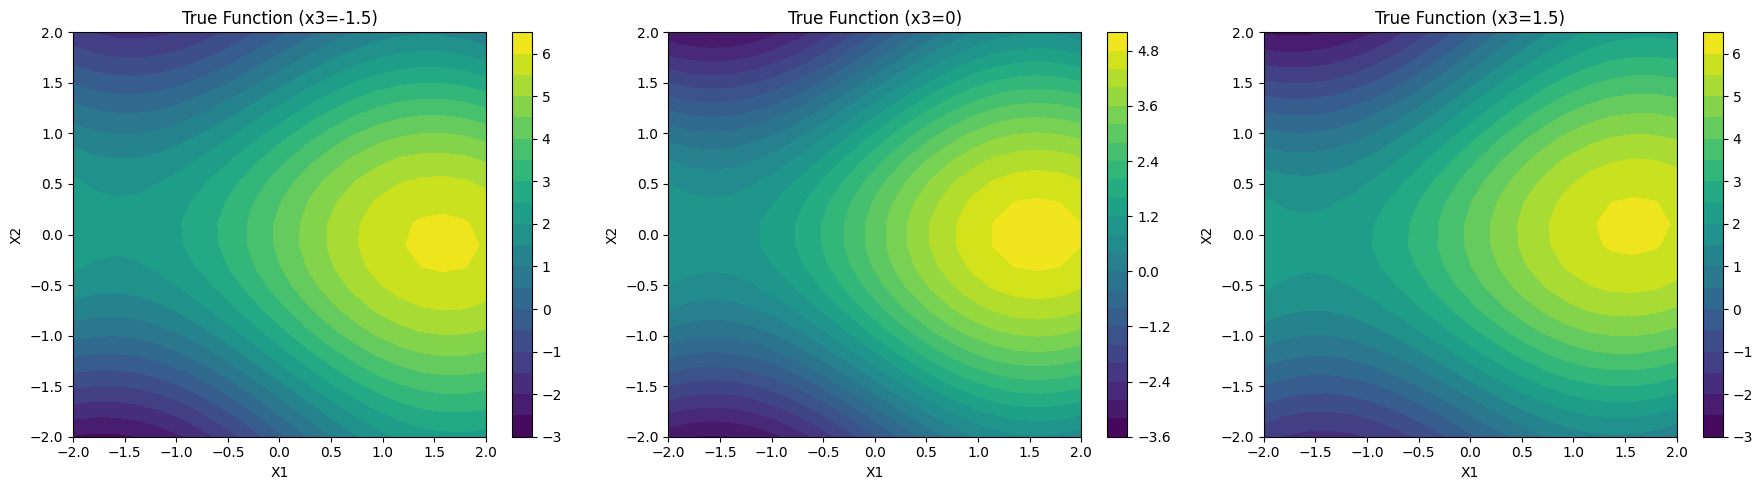

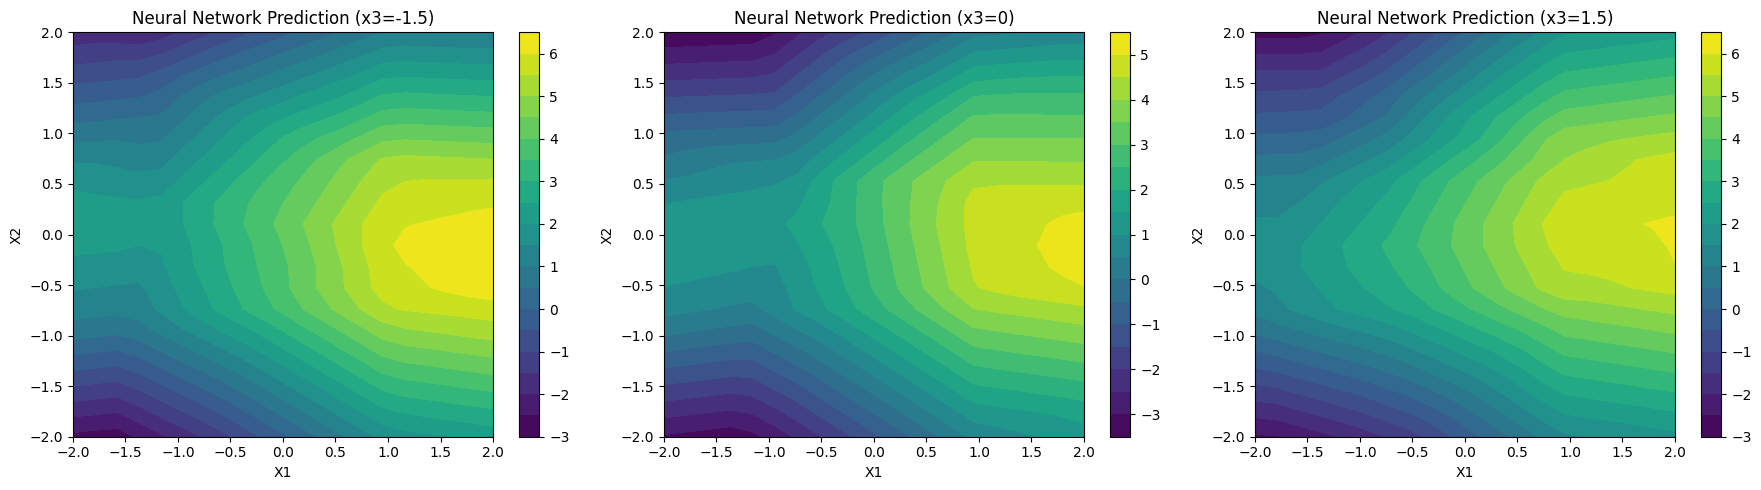

In [5]:
# Alternative visualization with 2D slices
def plot_2d_slices(X_range=2.0, grid_points=20):
    # Create a grid of points for visualization
    x1 = np.linspace(-X_range, X_range, grid_points)
    x2 = np.linspace(-X_range, X_range, grid_points)
    x3_values = [-1.5, 0, 1.5]  # Three fixed values for x3

    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model.forward(X_input).numpy().reshape(grid_points, grid_points)

        # Plot the true function
        im1 = axes[i].contourf(X1, X2, y_true, cmap='viridis', levels=20)
        axes[i].set_title(f'True Function (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im1, ax=axes[i])

    plt.tight_layout()
    plt.show()

    # Now plot the predicted function
    fig, axes = plt.subplots(1, len(x3_values), figsize=(18, 5))

    for i, x3 in enumerate(x3_values):
        # Create meshgrid for x1 and x2
        X1, X2 = np.meshgrid(x1, x2)

        # Create input data with fixed x3
        X_input_np = np.zeros((grid_points*grid_points, 3))
        X_input_np[:, 0] = X1.flatten()
        X_input_np[:, 1] = X2.flatten()
        X_input_np[:, 2] = x3

        # Convert to tensor
        X_input = tf.convert_to_tensor(X_input_np, dtype=tf.float32)

        # Get true values and predictions
        y_true = true_function(X_input).numpy().reshape(grid_points, grid_points)
        y_pred = model.forward(X_input).numpy().reshape(grid_points, grid_points)

        # Plot the predicted function
        im2 = axes[i].contourf(X1, X2, y_pred, cmap='viridis', levels=20)
        axes[i].set_title(f'Neural Network Prediction (x3={x3})')
        axes[i].set_xlabel('X1')
        axes[i].set_ylabel('X2')

        # Add a colorbar
        plt.colorbar(im2, ax=axes[i])

    plt.tight_layout()
    plt.show()

# Generate and plot 2D slices
plot_2d_slices(X_range=2.0, grid_points=20)

## Summary

In this notebook, we've implemented a 3-layer neural network using TensorFlow's low-level API. Key features of this implementation:

1. Manual definition of weights and biases using `tf.Variable`
2. Use of `einsum` for matrix operations as specified
3. Implementation of forward pass with ReLU activations
4. Gradient computation using `tf.GradientTape`
5. Custom training loop

This implementation gives us more control over the details of the neural network, while still leveraging TensorFlow's automatic differentiation capabilities. The model successfully learned to approximate our non-linear 3-variable function, with performance visualized through various plots and metrics.

The use of `einsum` provides a more flexible way to perform tensor operations compared to traditional matrix multiplication methods, allowing for clearer expression of the operations.